# S2F Performance Analysis

Use this notebook to explore the prediction outputs produced by different S2F runs and compare their behaviour. Each run writes a `prediction.df` file inside `<installation_directory>/output/<alias>/`. Update the configuration cells below with the aliases you want to analyse.

## Imports and configuration

The snippet below reads `s2f.conf` to locate the shared output directory. Adjust `CONFIG_PATH` if you are running the notebook from a different location.

In [11]:
from pathlib import Path
import configparser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 120)

sns.set_theme(style='whitegrid')

# Backwards-compatibility for deprecated NumPy aliases used by legacy modules
if not hasattr(np, 'float'):
    np.float = float  # type: ignore[attr-defined]
if not hasattr(np, 'int'):
    np.int = int  # type: ignore[attr-defined]
if not hasattr(np, 'bool'):
    np.bool = bool  # type: ignore[attr-defined]

CONFIG_PATH = Path('s2f.conf')
config = configparser.ConfigParser()
if not CONFIG_PATH.exists():
    raise FileNotFoundError(f'Configuration file not found: {CONFIG_PATH.resolve()}. Update CONFIG_PATH to match your setup.')
config.read(CONFIG_PATH)

BASE_OUTPUT = Path(config['directories']['installation_directory']).expanduser() / 'output'
if not BASE_OUTPUT.exists():
    raise FileNotFoundError(f'Output directory not found: {BASE_OUTPUT}. Make sure the S2F runs have been executed.')

FILTERED_GOA_PATH = Path(config.get('databases', 'filtered_goa', fallback='filtered_goa')).expanduser()
if not FILTERED_GOA_PATH.exists():
    raise FileNotFoundError(f'Filtered GOA file not found: {FILTERED_GOA_PATH}. Update FILTERED_GOA_PATH below if your data lives elsewhere.')

DEFAULT_OBO_PATH = Path('go.obo').resolve()
if not DEFAULT_OBO_PATH.exists():
    raise FileNotFoundError(f'GO ontology file not found: {DEFAULT_OBO_PATH}. Update DEFAULT_OBO_PATH to point at your go.obo file.')

BASE_OUTPUT

PosixPath('/media/marcelo_baez/HD_Disc1/.S2F/output')

## Discover available runs

This cell lists the aliases that currently have diffusion outputs. If the list is long, slice or filter it as needed.

In [2]:
AVAILABLE_RUNS = sorted(p.name for p in BASE_OUTPUT.iterdir() if p.is_dir())
print(f"{len(AVAILABLE_RUNS)} run(s) found under {BASE_OUTPUT}")
pd.DataFrame({'alias': AVAILABLE_RUNS})

6 run(s) found under /media/marcelo_baez/HD_Disc1/.S2F/output


,alias
0,test_1111708
1,test_1111708_new
2,test_1111708_new_2
3,test_223283
4,test_223283_new
5,test_223283_new_2


## Select runs to compare

Edit `RUNS_TO_COMPARE` to focus on the runs you are interested in. By default the cell keeps only aliases that actually exist in `AVAILABLE_RUNS`.

In [3]:
RUNS_TO_COMPARE = [
    'test_1111708',
    'test_1111708_new',
    # 'test_223283_new_2',
    'test_223283',
    'test_223283_new',
    'test_223283_new_2',
]

RUNS_TO_COMPARE = [alias for alias in RUNS_TO_COMPARE if alias in AVAILABLE_RUNS]
if not RUNS_TO_COMPARE:
    raise ValueError('Update RUNS_TO_COMPARE with at least one valid alias.')

RUNS_TO_COMPARE

['test_1111708',
 'test_1111708_new',
 'test_223283',
 'test_223283_new',
 'test_223283_new_2']

## Load prediction tables

Helper functions to read the prediction scores and the index files written by each run.

In [4]:
def load_predictions(alias: str, base_path: Path = BASE_OUTPUT) -> pd.DataFrame:
    """Load the diffusion output for a single run as a tidy DataFrame."""
    path = base_path / alias / 'prediction.df'
    if not path.exists():
        raise FileNotFoundError(f'Prediction file not found for {alias}: {path}')
    df = pd.read_csv(path, sep='	', header=None, names=['protein_id', 'term_id', 'score'])
    df['alias'] = alias
    return df


def load_terms(alias: str, base_path: Path = BASE_OUTPUT) -> pd.DataFrame:
    """Grab the GO term lookup table if you need term names or namespaces."""
    path = base_path / alias / 'terms.df'
    if not path.exists():
        raise FileNotFoundError(f'GO term index not found for {alias}: {path}')
    return pd.read_pickle(path)


def load_proteins(alias: str, base_path: Path = BASE_OUTPUT) -> pd.DataFrame:
    """Fetch the protein index for convenience (e.g. to map back to FASTA identifiers)."""
    path = base_path / alias / 'proteins.df'
    if not path.exists():
        raise FileNotFoundError(f'Protein index not found for {alias}: {path}')
    return pd.read_pickle(path)


In [5]:
predictions_df = pd.concat(
    [load_predictions(alias) for alias in RUNS_TO_COMPARE],
    ignore_index=True
)

print(f"Loaded {predictions_df.shape[0]:,} scored annotations spanning {predictions_df['alias'].nunique()} run(s).")
predictions_df.head()

Loaded 461,207,568 scored annotations spanning 5 run(s).


,protein_id,term_id,score,alias
0,O06944,GO:0000001,4.348398e-07,test_1111708
1,O06944,GO:0000006,1.679498e-07,test_1111708
2,O06944,GO:0000009,3.678006e-06,test_1111708
3,O06944,GO:0000010,1.639269e-07,test_1111708
4,O06944,GO:0000011,8.136905e-07,test_1111708


## Summary statistics per run

In [66]:
summary = (
    predictions_df
    .groupby('alias')
    .agg(
        proteins=('protein_id', 'nunique'),
        go_terms=('term_id', 'nunique'),
        annotations=('term_id', 'size'),
        min_score=('score', 'min'),
        median_score=('score', 'median'),
        mean_score=('score', 'mean'),
        max_score=('score', 'max')
    )
    .sort_index()
)
summary

: 

: 

## Focus on top-N predictions per protein

Restrict to the highest-scoring annotations per protein to study agreement between runs.

In [32]:
TOP_N = 5  # change to inspect more or fewer annotations per protein

_top_sorted = predictions_df.sort_values(
    ['alias', 'protein_id', 'score'],
    ascending=[True, True, False]
)

top_predictions = (
    _top_sorted
    .groupby(['alias', 'protein_id'], as_index=False)
    .head(TOP_N)
    .reset_index(drop=True)
)

top_predictions.head()

,protein_id,term_id,score,alias
0,A0PCI4,GO:0003674,0.569340,test_223283
1,A0PCI4,GO:0008150,0.502677,test_223283
2,A0PCI4,GO:0009987,0.502546,test_223283
3,A0PCI4,GO:0003824,0.502376,test_223283
4,A0PCI4,GO:0008152,0.502338,test_223283


## Pairwise comparison (first two runs)

The cell below contrasts the first two aliases in `RUNS_TO_COMPARE`. Edit `BASELINE` and `VARIANT` if you prefer a different pair.

In [31]:
if len(RUNS_TO_COMPARE) >= 2:
    BASELINE, VARIANT = RUNS_TO_COMPARE[0], RUNS_TO_COMPARE[1]

    baseline_top = (
        top_predictions[top_predictions['alias'] == BASELINE]
        [['protein_id', 'term_id', 'score']]
        .set_index(['protein_id', 'term_id'])
    )
    variant_top = (
        top_predictions[top_predictions['alias'] == VARIANT]
        [['protein_id', 'term_id', 'score']]
        .set_index(['protein_id', 'term_id'])
    )

    pairwise = baseline_top.join(
        variant_top,
        how='outer',
        lsuffix=f'_{BASELINE}',
        rsuffix=f'_{VARIANT}'
    )
    pairwise[f'score_{BASELINE}'] = pairwise.get(f'score_{BASELINE}', 0).fillna(0)
    pairwise[f'score_{VARIANT}'] = pairwise.get(f'score_{VARIANT}', 0).fillna(0)
    pairwise['score_delta'] = pairwise[f'score_{VARIANT}'] - pairwise[f'score_{BASELINE}']
    pairwise = pairwise.sort_values('score_delta', ascending=False)

    print(f'Comparing top-{TOP_N} predictions between {BASELINE} and {VARIANT}.')
    pairwise.head(20)
else:
    print('Add at least two aliases to RUNS_TO_COMPARE to compute pairwise deltas.')

NameError: name 'top_predictions' is not defined

## Largest improvements and regressions

Filter the `pairwise` table to highlight the strongest positive or negative score shifts.

In [ ]:
if len(RUNS_TO_COMPARE) >= 2 and 'pairwise' in globals():
    gains = pairwise[pairwise['score_delta'] > 0].head(20)
    losses = pairwise[pairwise['score_delta'] < 0].tail(20)

    print('Top gains:')
    display(gains)

    print('Top losses:')
    display(losses)
else:
    print('Pairwise deltas are not available — add at least two aliases and run the previous cell first.')

## Per-protein overlap statistics

Compute how much the top-N annotations overlap per protein between the first two runs.

In [ ]:
if len(RUNS_TO_COMPARE) >= 2:
    BASELINE, VARIANT = RUNS_TO_COMPARE[0], RUNS_TO_COMPARE[1]
    overlaps = []

    for protein_id, subset in top_predictions.groupby('protein_id'):
        alias_groups = {alias: group for alias, group in subset.groupby('alias')}
        if BASELINE not in alias_groups or VARIANT not in alias_groups:
            continue
        baseline_terms = set(alias_groups[BASELINE]['term_id'])
        variant_terms = set(alias_groups[VARIANT]['term_id'])
        union = baseline_terms | variant_terms
        if not union:
            continue
        shared = baseline_terms & variant_terms
        overlaps.append({
            'protein_id': protein_id,
            'shared': len(shared),
            'union': len(union),
            'jaccard': len(shared) / len(union)
        })

    overlap_df = pd.DataFrame(overlaps)
    print(f'Computed overlaps for {len(overlap_df)} proteins present in both runs.')
    overlap_df.sort_values('jaccard', ascending=False).head(20)
else:
    print('Add at least two aliases to RUNS_TO_COMPARE to evaluate overlap.')

## Ground truth configuration

Use the helpers below to discover metadata for the available runs and set up GOA-based evaluation parameters.

In [6]:
import re

def _parse_taxon_from_fasta(fasta_path):
    """Infer a taxon identifier from the FASTA file name."""
    stem = Path(fasta_path).stem
    match = re.search(r'(\d+)$', stem)
    if match:
        return match.group(1)
    digits = re.findall(r'\d+', stem)
    return digits[-1] if digits else None


def discover_run_metadata(run_config_paths):
    """Parse run configuration files to map aliases to useful metadata."""
    metadata = {}
    for conf_path in run_config_paths:
        parser = configparser.ConfigParser()
        parser.read(conf_path)
        if not parser.has_section('configuration'):
            continue
        alias = parser.get('configuration', 'alias', fallback='').strip()
        if not alias:
            continue
        entry = metadata.setdefault(alias, {})
        entry['run_config'] = conf_path
        if parser.has_option('configuration', 'fasta'):
            fasta_path = parser.get('configuration', 'fasta')
            entry['fasta'] = fasta_path
            taxon = _parse_taxon_from_fasta(fasta_path)
            if taxon:
                entry['taxon_id'] = taxon
    return metadata


# RUN_CONFIG_PATHS = sorted(Path('.').glob('run*.conf'))
RUN_CONFIG_PATHS = sorted(Path('.').glob('run*.conf'))
RUN_METADATA = discover_run_metadata(RUN_CONFIG_PATHS)

metadata_table = pd.DataFrame(
    [
        {
            'alias': alias,
            'run_config': str(meta.get('run_config')),
            'fasta': meta.get('fasta'),
            'taxon_id': meta.get('taxon_id'),
        }
        for alias, meta in RUN_METADATA.items()
    ]
).sort_values('alias').reset_index(drop=True) if RUN_METADATA else pd.DataFrame(columns=['alias', 'run_config', 'fasta', 'taxon_id'])

metadata_table

,alias,run_config,fasta,taxon_id
0,test_1111708,run_1111708.conf,/media/marcelo_baez/HD_Disc1/paper_data/111170...,1111708
1,test_1111708_new,run_1111708_new.conf,/media/marcelo_baez/HD_Disc1/paper_data/111170...,1111708
2,test_223283,run_223283.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283
3,test_223283_new,run_223283_new.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283
4,test_223283_new_2,run_223283_new_2.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283


In [7]:
# Change the alias names, remove the test_ prefixes

metadata_table['alias'] = metadata_table['alias'].str.replace(r'^test_', '', regex=True)
metadata_table

,alias,run_config,fasta,taxon_id
0,1111708,run_1111708.conf,/media/marcelo_baez/HD_Disc1/paper_data/111170...,1111708
1,1111708_new,run_1111708_new.conf,/media/marcelo_baez/HD_Disc1/paper_data/111170...,1111708
2,223283,run_223283.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283
3,223283_new,run_223283_new.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283
4,223283_new_2,run_223283_new_2.conf,/media/marcelo_baez/HD_Disc1/paper_data/223283...,223283


In [8]:
DEFAULT_EVIDENCE_CODES = [
    code.strip()
    for code in config.get('options', 'evidence_codes', fallback='EXP,IDA,IPI,IMP,IGI,IEP,TAS,IC').split(',')
    if code.strip()
]

GROUND_TRUTH_CONFIG = {
    alias: {
        'taxon_id': meta.get('taxon_id'),
        'goa_path': FILTERED_GOA_PATH,
        'obo_path': DEFAULT_OBO_PATH,
        'evidence_codes': DEFAULT_EVIDENCE_CODES,
        'min_annotations_per_protein': 1,
        'term_frequency_range': (1, None),
    }
    for alias, meta in RUN_METADATA.items()
    if meta.get('taxon_id')
}

GROUND_TRUTH_CONFIG

{'test_1111708': {'taxon_id': '1111708',
  'goa_path': PosixPath('/media/marcelo_baez/HD_Disc1/.S2F/data/UniprotKB/goa_uniprot_all.gaf'),
  'obo_path': PosixPath('/home/marcelo_baez/paccanaro-lab/S2F/go.obo'),
  'evidence_codes': ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP', 'TAS', 'IC'],
  'min_annotations_per_protein': 1,
  'term_frequency_range': (1, None)},
 'test_1111708_new': {'taxon_id': '1111708',
  'goa_path': PosixPath('/media/marcelo_baez/HD_Disc1/.S2F/data/UniprotKB/goa_uniprot_all.gaf'),
  'obo_path': PosixPath('/home/marcelo_baez/paccanaro-lab/S2F/go.obo'),
  'evidence_codes': ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP', 'TAS', 'IC'],
  'min_annotations_per_protein': 1,
  'term_frequency_range': (1, None)},
 'test_223283': {'taxon_id': '223283',
  'goa_path': PosixPath('/media/marcelo_baez/HD_Disc1/.S2F/data/UniprotKB/goa_uniprot_all.gaf'),
  'obo_path': PosixPath('/home/marcelo_baez/paccanaro-lab/S2F/go.obo'),
  'evidence_codes': ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP', 'TA

In [9]:
from Measures.measures import HX_py
from GOTool.GeneOntology import GeneOntology

_GOA_CACHE = {}


def load_goa_annotations_for_taxon(taxon_id, goa_path, evidence_codes, chunk_size=200_000):
    """Load GOA annotations for a single taxon from a potentially large GOA file."""
    goa_path = Path(goa_path)
    if not goa_path.exists():
        raise FileNotFoundError(f'GOA file not found: {goa_path}')
    cache_key = (goa_path.resolve(), str(taxon_id), tuple(sorted(evidence_codes)) if evidence_codes else ())
    if cache_key in _GOA_CACHE:
        return _GOA_CACHE[cache_key].copy()

    column_names = [
        'DB', 'DB Object ID', 'DB Object Symbol', 'Qualifier', 'GO ID',
        'DB Reference', 'Evidence Code', 'With', 'Aspect', 'DB Object Name',
        'Synonym', 'DB Object Type', 'Taxon', 'Date', 'Assigned By',
        'Annotation Extension', 'Gene Product Form ID'
    ]
    dtype = {name: str for name in column_names}
    pattern = fr'(?:^|\|)taxon:{taxon_id}(?:$|\|)'
    annotations = []

    for chunk in pd.read_csv(
        goa_path,
        sep='	',
        comment='!',
        header=None,
        names=column_names,
        dtype=dtype,
        chunksize=chunk_size,
        low_memory=False,
    ):
        mask = chunk['Taxon'].fillna('').str.contains(pattern, regex=True)
        if not mask.any():
            continue
        subset = chunk.loc[mask]
        if evidence_codes:
            subset = subset[subset['Evidence Code'].isin(evidence_codes)]
            if subset.empty:
                continue
        trimmed = subset[['DB Object ID', 'GO ID']].drop_duplicates()
        trimmed = trimmed.rename(columns={'DB Object ID': 'Protein'})
        trimmed['Score'] = 1.0
        annotations.append(trimmed)

    if annotations:
        result = pd.concat(annotations, ignore_index=True)
    else:
        result = pd.DataFrame(columns=['Protein', 'GO ID', 'Score'])

    _GOA_CACHE[cache_key] = result
    return result.copy()


def build_prediction_and_gold_matrices(predictions, annotations):
    if predictions.empty:
        raise ValueError('Prediction table is empty for the requested alias.')
    if annotations.empty:
        raise ValueError('Ground-truth annotations are empty for the requested taxon.')

    proteins = sorted(set(predictions['protein_id']) | set(annotations['Protein']))
    terms = sorted(set(predictions['term_id']) | set(annotations['GO ID']))

    protein_to_idx = {protein: idx for idx, protein in enumerate(proteins)}
    term_to_idx = {term: idx for idx, term in enumerate(terms)}

    prediction_matrix = np.zeros((len(proteins), len(terms)), dtype=np.float32)
    rows = predictions['protein_id'].map(protein_to_idx).to_numpy()
    cols = predictions['term_id'].map(term_to_idx).to_numpy()
    prediction_matrix[rows, cols] = predictions['score'].to_numpy(dtype=float)

    gold_matrix = np.zeros((len(proteins), len(terms)), dtype=np.float32)
    gt_rows = annotations['Protein'].map(protein_to_idx).to_numpy()
    gt_cols = annotations['GO ID'].map(term_to_idx).to_numpy()
    gold_matrix[gt_rows, gt_cols] = 1.0

    return prediction_matrix, gold_matrix, protein_to_idx, term_to_idx


def compute_information_content(term_to_idx, ontology, organism_name):
    ic = np.zeros(len(term_to_idx), dtype=np.float32)
    for term, idx in term_to_idx.items():
        try:
            ic[idx] = ontology.find_term(term).information_content(organism_name)
        except KeyError:
            ic[idx] = 0.0
    return ic


def filter_matrices(gold_matrix, prediction_matrix, ic_vector, min_annotations_per_protein=3, term_frequency_range=(1, 1_000_000)):
    lower, upper = term_frequency_range
    upper = float('inf') if upper is None else upper

    sumrow = gold_matrix.sum(axis=1)
    sumcol = gold_matrix.sum(axis=0)

    row_mask = sumrow >= min_annotations_per_protein
    col_mask = (sumcol >= lower) & (sumcol <= upper)

    filtered_pred = prediction_matrix[row_mask][:, col_mask]
    filtered_gold = gold_matrix[row_mask][:, col_mask]
    filtered_ic = ic_vector[col_mask]

    return filtered_pred, filtered_gold, filtered_ic, row_mask, col_mask


def evaluate_alias(alias, predictions_df, alias_cfg):
    alias_predictions = predictions_df[predictions_df['alias'] == alias].copy()
    if alias_predictions.empty:
        raise ValueError('No predictions found for this alias in predictions_df.')

    taxon_id = alias_cfg.get('taxon_id')
    if not taxon_id:
        raise ValueError('Taxon identifier is missing from GROUND_TRUTH_CONFIG.')

    goa_path = alias_cfg.get('goa_path', FILTERED_GOA_PATH)
    evidence_codes = alias_cfg.get('evidence_codes', DEFAULT_EVIDENCE_CODES)
    annotations = load_goa_annotations_for_taxon(taxon_id, goa_path, evidence_codes)
    if annotations.empty:
        raise ValueError('No annotations retrieved from GOA for the selected taxon and evidence codes.')

    organism_name = f'gt_{alias}'
    ontology_path = alias_cfg.get('obo_path', DEFAULT_OBO_PATH)
    ontology = GeneOntology(str(ontology_path), verbose=False)
    ontology.build_structure()
    ontology.load_annotations(annotations, organism_name)
    ontology.up_propagate_annotations(organism_name)
    propagated_annotations = ontology.get_annotations(organism_name)

    prediction_matrix, gold_matrix, protein_to_idx, term_to_idx = build_prediction_and_gold_matrices(alias_predictions, propagated_annotations)
    ic_vector = compute_information_content(term_to_idx, ontology, organism_name)

    freq_range = alias_cfg.get('term_frequency_range', (1, 1_000_000))
    min_ann = alias_cfg.get('min_annotations_per_protein', 3)
    filtered_pred, filtered_gold, filtered_ic, row_mask, col_mask = filter_matrices(
        gold_matrix,
        prediction_matrix,
        ic_vector,
        min_annotations_per_protein=min_ann,
        term_frequency_range=freq_range,
    )

    if filtered_gold.size == 0 or filtered_gold.sum() == 0:
        raise ValueError('No overlapping annotations left after filtering criteria were applied.')

    if np.unique(filtered_pred).size > 10000:
        filtered_pred = np.around(filtered_pred, decimals=4)

    measure = HX_py(filtered_pred, filtered_ic, organism_id=alias, verbose=False)
    results = {
        'overall': measure.compute_overall(filtered_gold),
        'per_gene': measure.compute_per_gene(filtered_gold),
        'per_term': measure.compute_per_term(filtered_gold),
    }
    context = {
        'proteins_considered': int(row_mask.sum()),
        'terms_considered': int(col_mask.sum()),
        'total_annotations': int(filtered_gold.sum()),
        'matrix_shape': filtered_gold.shape,
    }
    return results, context


def flatten_metrics(nested_metrics):
    flat = {}
    for block, metrics in nested_metrics.items():
        for key, value in metrics.items():
            if isinstance(value, (list, tuple, dict)):
                continue
            arr = np.asarray(value)
            if arr.ndim == 0:
                label = key if block != 'overall' else f'{block}::{key}'
                flat[label] = float(arr)
    return flat

In [ ]:
EVALUATION_RESULTS = {}
EVALUATION_CONTEXT = {}
EVALUATION_SUMMARY = []
EVALUATION_ERRORS = []

for alias in RUNS_TO_COMPARE:
    cfg = GROUND_TRUTH_CONFIG.get(alias)
    if cfg is None:
        print(f'Skipping {alias}: no ground truth configuration available.')
        continue
    try:
        metrics, context = evaluate_alias(alias, predictions_df, cfg)
    except Exception as exc:
        print(f'{alias}: {exc}')
        EVALUATION_ERRORS.append({'alias': alias, 'error': str(exc)})
        continue

    EVALUATION_RESULTS[alias] = metrics
    EVALUATION_CONTEXT[alias] = context

    flattened = flatten_metrics(metrics)
    row = {'alias': alias, **flattened}
    EVALUATION_SUMMARY.append(row)

if EVALUATION_SUMMARY:
    display(pd.DataFrame(EVALUATION_SUMMARY).set_index('alias'))
else:           
    print('No successful evaluations were recorded.')


,overall::AUC,overall::AUPR,overall::Precision at 0.2 Recall,overall::F_max,overall::NDCG,overall::Jaccard,overall::smin,AUC per-gene,AUPR per-gene,Precision at 0.2 Recall per-gene,F_max per-gene,NDCG per-gene,Jaccard per-gene,smin per-gene,AUC per-term,AUPR per-term,Precision at 0.2 Recall per-term,F_max per-term,NDCG per-term,Jaccard per-term,smin per-term
alias,,,,,,,,,,,,,,,,,,,,,
test_1111708,0.952723,0.393885,1.0,0.499330,0.877063,0.332738,84.111832,0.968335,0.481539,0.733553,0.662030,0.782285,0.535435,0.110917,0.927084,0.209291,0.505482,0.640884,0.702370,0.553767,0.148753
test_1111708_new,0.948538,0.374370,1.0,0.460790,0.873015,0.299368,84.998617,0.966408,0.471695,0.707237,0.658882,0.782069,0.537547,0.109503,0.929562,0.212959,0.487939,0.649980,0.703910,0.564565,0.174267
test_223283,0.784106,0.408627,1.0,0.473013,0.858079,0.309769,98.687679,0.813519,0.397305,0.653846,0.572725,0.735637,0.444735,0.457346,0.749560,0.247511,0.410405,0.544595,0.625302,0.434429,0.713138
test_223283_new,0.777948,0.368867,1.0,0.466863,0.839987,0.304515,104.625027,0.813085,0.364900,0.692308,0.564380,0.723008,0.435789,0.456601,0.752124,0.240568,0.393064,0.538307,0.621671,0.422330,0.736587
test_223283_new_2,0.787866,0.396324,1.0,0.471414,0.852927,0.308399,97.825768,0.819030,0.379474,0.730769,0.574547,0.739965,0.442168,0.457178,0.760536,0.236344,0.485549,0.539568,0.638237,0.423843,0.736724


In [13]:
metrics_df = pd.DataFrame(EVALUATION_SUMMARY).set_index('alias') if EVALUATION_SUMMARY else pd.DataFrame()
if not metrics_df.empty:
    TARGET_METRICS = ('AUC', 'AUPR', 'F_max', 'smin')
    metrics_df = metrics_df[[
        col for col in metrics_df.columns
        if any(metric.lower() in col.lower() for metric in TARGET_METRICS)
    ]]
    metrics_df.sort_index(inplace=True)
metrics_df

,overall::AUC,overall::AUPR,overall::F_max,overall::smin,AUC per-gene,AUPR per-gene,F_max per-gene,smin per-gene,AUC per-term,AUPR per-term,F_max per-term,smin per-term
alias,,,,,,,,,,,,
test_1111708,0.952723,0.393885,0.499330,84.111832,0.968335,0.481539,0.662030,0.110917,0.927084,0.209291,0.640884,0.148753
test_1111708_new,0.948538,0.374370,0.460790,84.998617,0.966408,0.471695,0.658882,0.109503,0.929562,0.212959,0.649980,0.174267
test_223283,0.784106,0.408627,0.473013,98.687679,0.813519,0.397305,0.572725,0.457346,0.749560,0.247511,0.544595,0.713138
test_223283_new,0.777948,0.368867,0.466863,104.625027,0.813085,0.364900,0.564380,0.456601,0.752124,0.240568,0.538307,0.736587
test_223283_new_2,0.787866,0.396324,0.471414,97.825768,0.819030,0.379474,0.574547,0.457178,0.760536,0.236344,0.539568,0.736724


In [60]:
context_df = pd.DataFrame.from_dict(EVALUATION_CONTEXT, orient='index') if EVALUATION_CONTEXT else pd.DataFrame()
context_df

,proteins_considered,terms_considered,total_annotations,matrix_shape
test_1111708,152,456,2194,"(152, 456)"
test_1111708_new,152,456,2194,"(152, 456)"


In [44]:
pd.DataFrame(EVALUATION_ERRORS) if EVALUATION_ERRORS else pd.DataFrame(columns=['alias', 'error'])

,alias,error


## Visualising evaluation metrics

The cells below chart overall, per-gene, and per-term metrics using grouped bar plots (one subplot per metric).

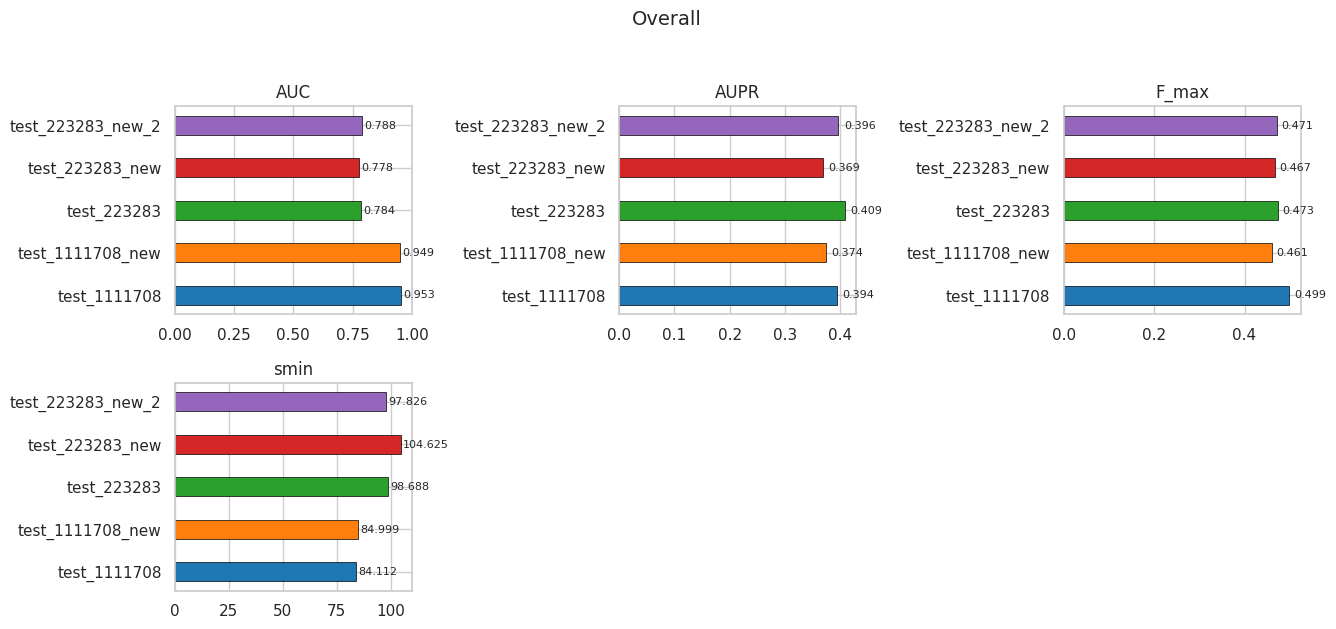

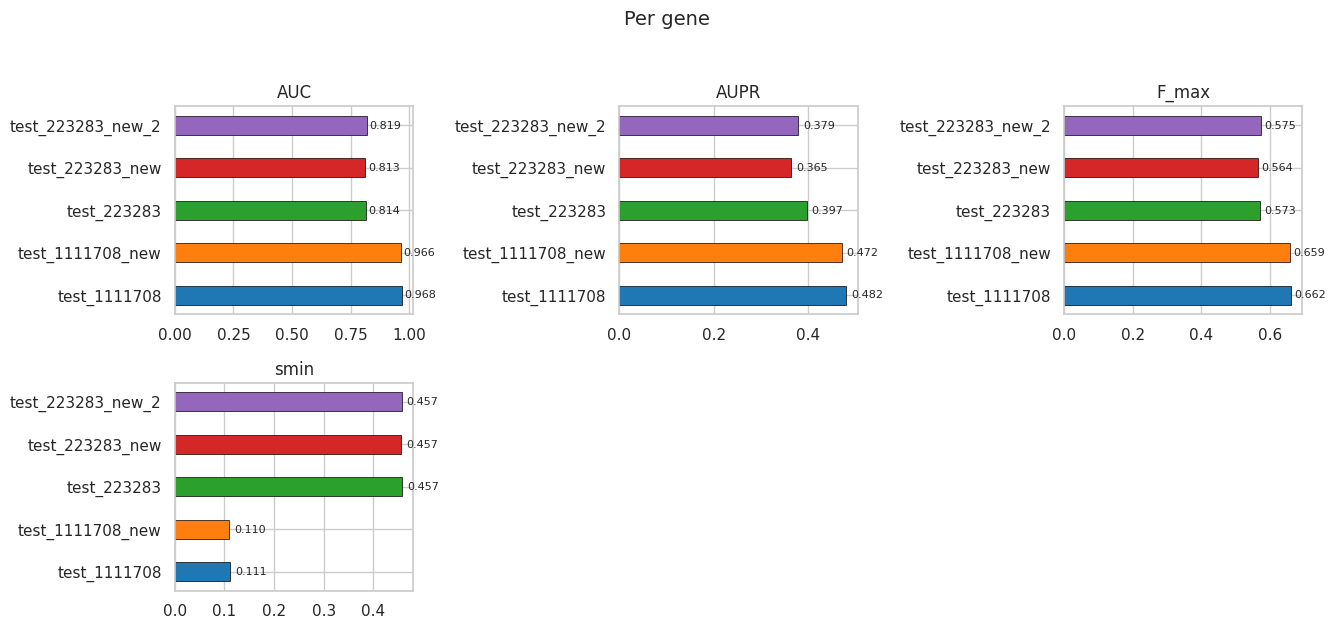

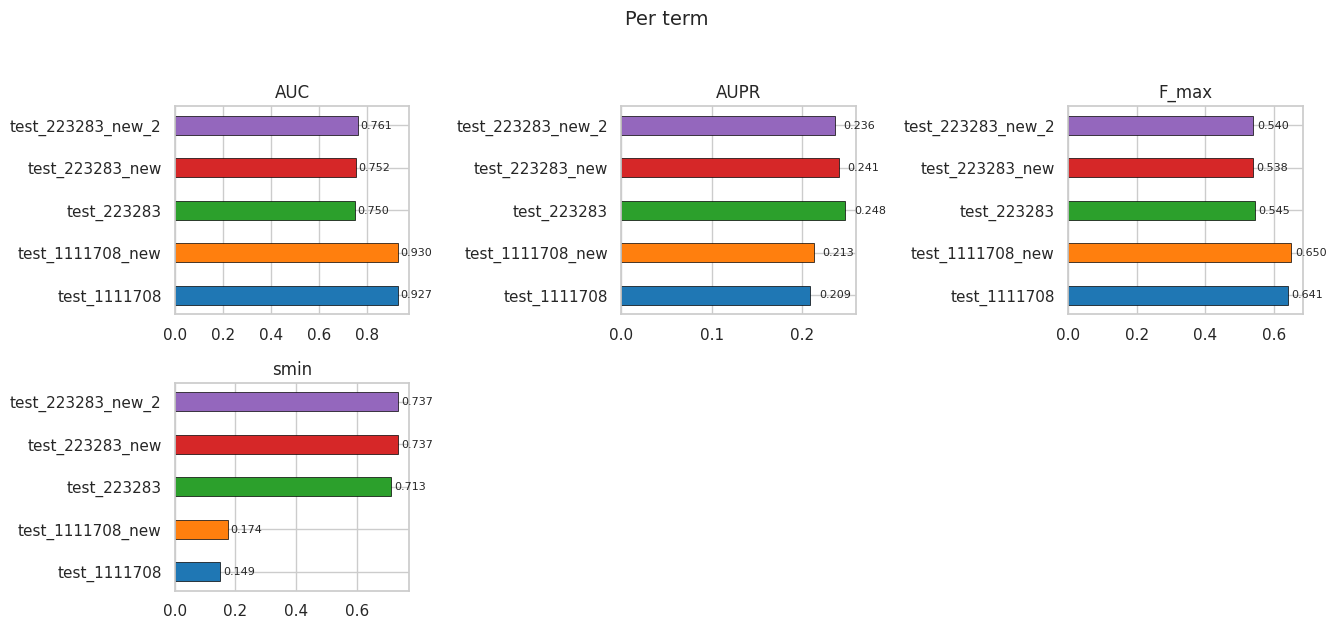

In [14]:
if metrics_df.empty:
    raise ValueError('metrics_df is empty. Run the evaluation cell above first.')

metrics_df = metrics_df.copy()
metrics_df.index.name = 'alias'
metrics_df.sort_index(inplace=True)

aliases = metrics_df.index.tolist()
if not aliases:
    raise ValueError('No aliases found in metrics_df.')

palette = sns.color_palette('tab10', n_colors=len(aliases))
alias_colors = dict(zip(aliases, palette))

block_specs = {
    'Overall': lambda col: col.startswith('overall::'),
    'Per gene': lambda col: 'per-gene' in col,
    'Per term': lambda col: 'per-term' in col,
}

for block_title, selector in block_specs.items():
    block_columns = [col for col in metrics_df.columns if selector(col)]
    if not block_columns:
        print(f'No metrics found for {block_title}. Skipping.')
        continue

    block_data = metrics_df[block_columns]

    def _clean_metric_name(name: str) -> str:
        if '::' in name:
            name = name.split('::', 1)[1]
        name = name.replace(' per-gene', '').replace(' per-term', '')
        return name

    metric_names = [_clean_metric_name(col) for col in block_columns]
    n_metrics = len(block_columns)
    ncols = min(3, n_metrics)
    nrows = int(np.ceil(n_metrics / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4.5 * ncols, 3.2 * nrows), squeeze=False)
    fig.suptitle(f'{block_title}', fontsize=14)

    bar_height = 0.45
    y_positions = np.arange(len(aliases))

    for idx, (col, metric_name) in enumerate(zip(block_columns, metric_names)):
        ax = axes[idx // ncols][idx % ncols]
        values = block_data[col].astype(float).reindex(aliases)
        colors = [alias_colors[a] for a in aliases]
        bars = ax.barh(y_positions, values, height=bar_height, color=colors, edgecolor='black', linewidth=0.5)

        ax.set_title(metric_name)
        # ax.set_ylabel('Alias')
        # ax.set_xlabel(metric_name)
        ax.set_yticks(y_positions)
        ax.set_yticklabels(aliases)

        max_abs = max(abs(values).max(), 1)
        offset = 0.01 * max_abs
        for rect, value in zip(bars, values):
            y = rect.get_y() + rect.get_height() / 2
            if value >= 0:
                ax.text(value + offset, y, f'{value:.3f}', va='center', ha='left', fontsize=8)
            else:
                ax.text(value - offset, y, f'{value:.3f}', va='center', ha='right', fontsize=8)

    total_axes = nrows * ncols
    for j in range(n_metrics, total_axes):
        fig.delaxes(axes[j // ncols][j % ncols])

    handles = [
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=alias_colors[alias], # noqa
                   markeredgecolor='black', markersize=8, label=alias)
        for alias in aliases
    ]
    # fig.legend(handles=handles, loc='upper right', title='Alias', frameon=False)
    fig.tight_layout(rect=[0, 0, 1, 0.95]) # type: ignore

plt.show()